# DyGIE++ co-occurrence entity characterization and grounding

In [1]:
import networkx as nx
from collections import defaultdict, Counter
import taxoniq
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import json
import pandas as pd
import timeit
from functools import partial

## Read in data

In [2]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_02May2024.graphml')

## Basic characterization

In [3]:
ents_by_type = defaultdict(list)
for n, attrs in graph.nodes(data=True):
    ents_by_type[attrs['ent_type']].append(n)

### Check database grounding potential for `Multi`- and `Unicellular_organism` types

In [4]:
grounded_multicell = {}
for n in ents_by_type['Multicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_multicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_multicell)} of {len(ents_by_type["Multicellular_organism"])} multicellular organisms could be grounded')

14 of 156081 multicellular organisms could be grounded


In [5]:
grounded_unicell = {}
for n in ents_by_type['Unicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_unicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_unicell)} of {len(ents_by_type["Unicellular_organism"])} unicellular organisms could be grounded')

0 of 3260 unicellular organisms could be grounded


Grounding capacity directly using taxoniq is horrendous. What happens if we concatenate all of the species mentions together and use TaxoNERD, like we did for citation network classification? We're going to write a mini script and submit this as a job, because TaxoNERD grounding is exceedingly slow.

In [6]:
# with open('../data/kg/full_graph_multicellular_ents_02May2024.txt', 'w') as f:
#     f.write("\n".join(ents_by_type['Multicellular_organism']))

In [7]:
with open('../data/kg/full_graph_multicellular_ents_GROUNDED_02May2024.json') as f:
    grounded_ents = json.load(f)

In [8]:
print(f'There are {len(grounded_ents)} that received a grounding, and {len(set(grounded_ents.values()))} unique groundings.')

There are 51404 that received a grounding, and 21433 unique groundings.


This is great news! It means that a bunch of entities got resolved, even though we didn't get groundings for many of the entities.

In [74]:
groundings_to_ents = defaultdict(list)
for ent, grd in grounded_ents.items():
    groundings_to_ents[grd].append(ent)

### Appearance of study organisms over time
We'll get the top twenty species in the graph based on both the number of mentions of each node, as well as the number of different nodes with the same Taxonomy ID, and then look at when they appear over time. We'll sum the mentions for any entities that resolve to the same grounded TaxonID.

In [46]:
ent_mentions = nx.get_node_attributes(graph, 'num_doc_mentions_all_time')
multi_mentions = {ent: ent_mentions[ent] for ent in ents_by_type['Multicellular_organism']}

In [61]:
organism_year_mentions = {}
for organism in multi_mentions.keys():
    year_mentions = {}
    attrs = graph.nodes[organism]
    for attr, val in attrs.items():
        if ('num_mentions_' in attr) and (attr != 'num_doc_mentions_all_time'):
            year = attr.split('_')[-1]
            if year != '2023':
                year_mentions[int(year)] = val
    organism_year_mentions[organism] = year_mentions

In [56]:
# Resolve them
resolved_groups = defaultdict(list)
for org, year_mentions in organism_year_mentions.items():
    if org in grounded_ents.keys():
        try:
            sci_name = taxoniq.Taxon(int(grounded_ents[org])).scientific_name
            resolved_groups[sci_name].append(year_mentions)
        except KeyError:
            resolved_groups[org].append(year_mentions)
    else:
        resolved_groups[org].append(year_mentions)

resolved_mentions = {}
for org, mention_dicts in resolved_groups.items():
    if len(mention_dicts) == 1:
        resolved_mentions[org] = mention_dicts[0]
    else:
        combined = Counter()
        for i in mention_dicts:
            combined += Counter(i)
        resolved_mentions[org] = combined

In [71]:
top_twenty_resolved = dict(sorted(resolved_mentions.items(), key=lambda x:sum(x[1].values()), reverse=True)[:20])

In [72]:
cmap = matplotlib.cm.get_cmap('tab20c')
organism_colors_resolved = {organism: rgb2hex(cmap(i)) for i, organism in enumerate(top_twenty_resolved.keys())}

/tmp/local/35321009/ipykernel_23006/2909574117.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab20c')


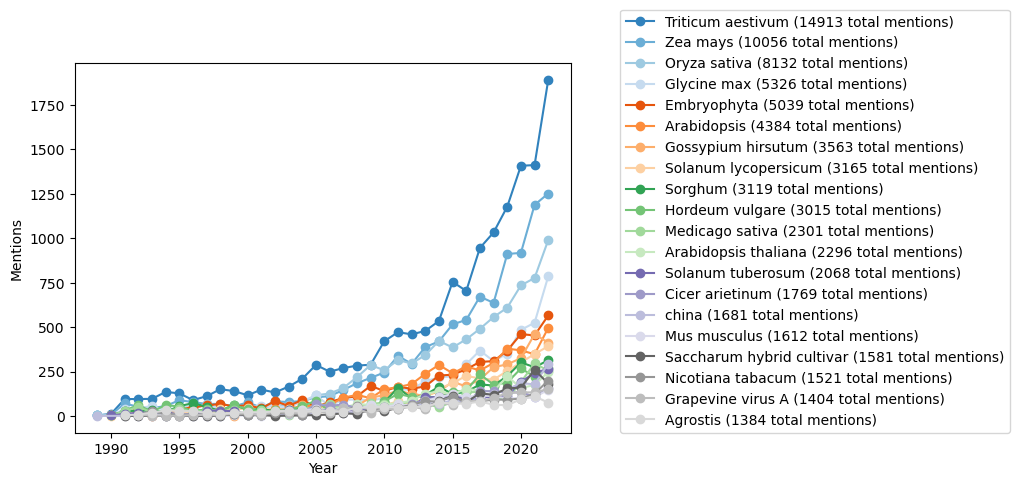

In [73]:
for org in top_twenty_resolved.keys():
    x = sorted(resolved_mentions[org].keys())
    y = [resolved_mentions[org][i] for i in x]
    color = organism_colors_resolved[org]
    plt.plot(x, y, color=color, marker='o', label=f'{org} ({sum(top_twenty_resolved[org].values())} total mentions)')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.legend(loc=(1.1,0.0))

What is up with mice appearing in the top 20 of organisms?

In [75]:
groundings_to_ents['10090']

['transgenic rice plants',
 'transgenic rice',
 'transgenic plants',
 'transgenic tomato',
 'transgenic lines',
 'transgenic lettuce',
 'transgenic rice lines',
 'transgenic rice cultivars',
 'transgenic clones',
 'transgenic arabidopsis and rice',
 'transgenic canola',
 'transgenic plant',
 'transgenic apple',
 'transgenic poplar',
 'transgenic mice',
 'tolerant transgenic rice',
 'transgenic line',
 'non-transgenic rice',
 'transgenic calli',
 'transgenic p. patens',
 'app/ps1 transgenic mice',
 'transgenic ( tg ) mice',
 'ataf1 transgenic rice',
 'bruge1 transgenic rice',
 'transgenic line 11',
 'rice transgenic plants',
 'transgenic plant lines',
 'transgenic rice plant',
 'transgenic',
 'rice transgenic lines',
 'non-transgenic mice',
 'transgenic trees',
 'transgenic birch',
 'ad transgenic mice',
 'transgenic tomato |',
 'transgenic crops',
 'house mouse',
 'mus musculus',
 'oscipk transgenic rice',
 'transgenic camelina',
 'ice1 transgenic lines',
 'transgenic plum lines',
 'tr

Apparently, anything that contains the word "transgenic" gets mapped to mice, which is... absolutely bizzare.

### Genes and proteins directly connected to an organism mention
One way we can identify genes/proteins that belong to various species in our graph is to check whether they are directly connected to an organism mention. The original intention of the is-in relation was to perform this kind of linking. Since we couldn't use typed relations and instead had to rely on co-occurrence, we'll treat any link as a possible is-in link.

In [14]:
ent_types = nx.get_node_attributes(graph, 'ent_type')
genes_by_organism = {}
proteins_by_organism = {}
for n in ents_by_type['Multicellular_organism']:
    neighbors = graph.neighbors(n)
    genes = []
    proteins = []
    for m in neighbors:
        if ent_types[m] in ['DNA', 'RNA']:
            genes.append(m)
        elif ent_types[m] == 'Protein':
            proteins.append(m)
    genes_by_organism[n] = genes
    proteins_by_organism[n] = proteins

If we use the oversimplification that any true Arabidopsis genes would start with `at`, then we can check what percentage of the connections are "correct":

In [15]:
correct_arabidopsis = [g for g in genes_by_organism['arabidopsis'] if g[:2] == 'at']
print(f'Assuming correct genes will start with At, {(len(correct_arabidopsis)/len(genes_by_organism["arabidopsis"]))*100:.2f} percent of genes directly connected to Arabidopsis are correct.')

Assuming correct genes will start with At, 8.48 percent of genes directly connected to Arabidopsis are correct.


In [16]:
print(f'{len(genes_by_organism["arabidopsis"])} of {graph.degree("arabidopsis")} edges ({(len(genes_by_organism["arabidopsis"])/graph.degree("arabidopsis"))*100:.2f}%) from the node "arabidopsis" are to genes.')
print(f'{len(proteins_by_organism["arabidopsis"])} of {graph.degree("arabidopsis")} edges ({(len(proteins_by_organism["arabidopsis"])/graph.degree("arabidopsis"))*100:.2f}%) from the node "arabidopsis" are to proteins.')

2039 of 7269 edges (28.05%) from the node "arabidopsis" are to genes.
2588 of 7269 edges (35.60%) from the node "arabidopsis" are to proteins.
